<a href="https://colab.research.google.com/github/codithj/stock_prediction_with_ml/blob/main/stock_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**구글 드라이브 연동**

In [11]:
import os
print(os.getcwd())
!ls


/content
gdrive	sample_data


In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')





Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


**라이브러리 임포팅**

In [13]:
import os
import sys
import warnings
if not sys.warnoptions:
  warnings.simplefilter('ignore')
import time
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd

**S&P500 index 데이터 불러오기**


In [14]:

df = pd.read_csv("/content/gdrive/My Drive/study/data/sp500_index.csv",
                 usecols=[0,1,2,3,4],
                 index_col=[0],
                 parse_dates=True)

print((df.isna().sum()))
df.tail()

Open     0
High     0
Low      0
Close    0
dtype: int64


,Open,High,Low,Close
Date,,,,
2021-01-13,3802.229980,3820.959961,3791.500000,3809.840088
2021-01-14,3814.979980,3823.600098,3792.860107,3795.540039
2021-01-15,3788.729980,3788.729980,3749.620117,3768.250000
2021-01-19,3781.879883,3804.530029,3780.370117,3798.909912
2021-01-20,3816.219971,3839.479980,3816.219971,3839.479980


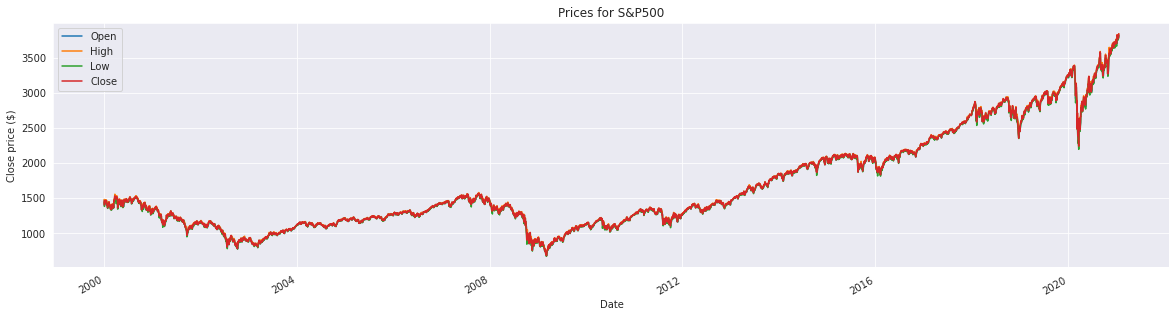

In [15]:
df.plot(figsize=(20, 5))
plt.title('Prices for S&P500')
plt.ylabel('Close price ($)')
plt.legend(loc='best')
plt.show()

**훈련, 테스트 데이터 준비**


In [16]:
# 손실함수 MAPE
def mean_absolute_percentage_error(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# 훈련, 테스트, 검증 데이터로 분리
def split_sequence(sequence, time_steps, train_size):
  X = list()
  y = list()

  for i in range(len(sequence)):
    # 배열의 끝인지 확인
    offset = i + time_steps
    if offset > len(sequence) - 1:
      break

    # 입력과 출력 분리
    seq_x = sequence[i:offset]
    seq_y = sequence[offset]

    X.append(seq_x)
    y.append(seq_y)

  split_X = int(len(X) * train_size)
  split_y = int(len(y) * train_size)

  # 훈련 데이터
  X_train = np.array(X[:split_X])
  y_train = np.array(y[:split_y])

  split_x_val = int(len(X[int(split_X):]) * 0.5)
  split_y_val = int(len(y[int(split_y):]) * 0.5)
  print(f'훈련데이터 사이즈: {(split_x_val, split_y_val)}')

  # 테스트 데이터
  X_test = np.array(X[split_X:(split_X + split_x_val)])
  y_test = np.array(y[split_y:(split_y + split_y_val)])

  # 검증 데이터
  X_val = np.array(X[(split_X + split_x_val):])
  y_val = np.array(y[(split_y + split_y_val):])

  return X_train, X_test, y_train, y_test, X_val, y_val

In [31]:
# 입력 시퀀스
raw_seq = list(df['Close'].values)
raw_seq_len = len(raw_seq)
raw_seq_desc = str(raw_seq_len) + ' days, ' + str(raw_seq_len / 5) + ' weeks';
print(f'입력 데이터의 기간:  {raw_seq_desc}')

# time steps 설정
time_steps = 6

# 데이터 분리
X_train, X_test, y_train, y_test, X_val, y_val = split_sequence(raw_seq,
                                                                time_steps,
                                                                train_size=0.9)
# 데이터 현황
print('데이터 현황: ',
      (len(X_train),
       len(X_test),
       len(X_val),
       len(y_train),
       len(y_test),
       len(y_val)))

model_name = {}

입력 데이터의 기간:  5296 days, 1059.2 weeks
훈련데이터 사이즈: (264, 264)
데이터 현황:  (4761, 264, 265, 4761, 264, 265)


**Prediction with LSTM**

In [32]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

# LSTM 모델
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(200,
                         activation='relu',
                         input_shape=(time_steps, n_features)),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mape')
print((model_lstm.summary()))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# fit model
fit_model = model_lstm.fit(
  X_train,
  y_train,
  epochs=50,
  verbose=2,
  callbacks=[tf.keras.callbacks.EarlyStopping()],
  validation_data=(X_val, y_val))

Epoch 1/50
149/149 - 4s - loss: 5.1823 - val_loss: 1.9018
Epoch 2/50
149/149 - 2s - loss: 1.5835 - val_loss: 2.2939


In [34]:
# prediction 결과
predict_val = model_lstm.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, predict_val), 3)
mape = round(mean_absolute_percentage_error(y_test, predict_val), 3)

file_model = './models/lstm.h5'
model_name[r2] = file_model
print(f'모델 위치: {model_name}')
model_lstm.save(file_model)

print(f'결과 -> r2: {r2} MAPE: {mape}')

모델 위치: {0.93: './models/lstm.h5'}
결과 -> r2: 0.93 MAPE: 6.528


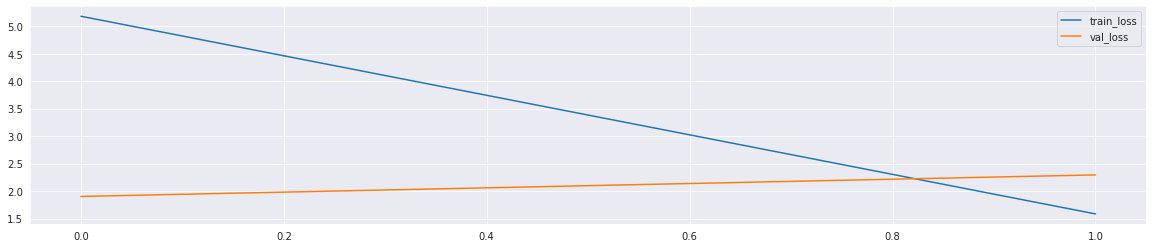

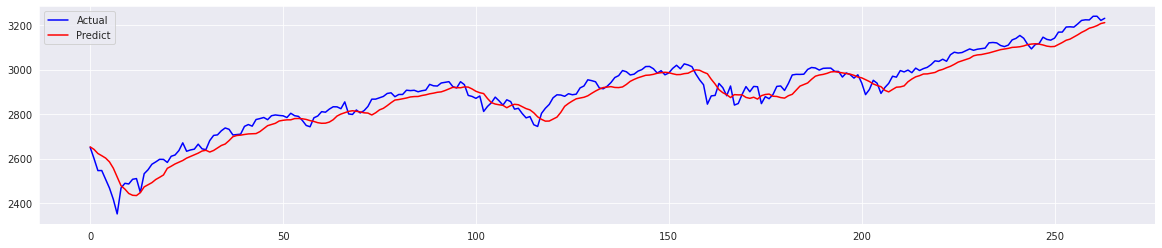

In [35]:
plt.figure(figsize=(20, 4))
plt.plot(fit_model.history['loss'], label='train_loss')
plt.plot(fit_model.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(predict_val, color='r', label='Predict')
plt.legend(loc='best')
plt.show()